In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=['pickup_datetime'])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


,missing_value,%
fare_amount,0,0.00
pickup_datetime,0,0.00
pickup_longitude,0,0.00
pickup_latitude,0,0.00
dropoff_longitude,0,0.00
dropoff_latitude,0,0.00
passenger_count,1,0.01


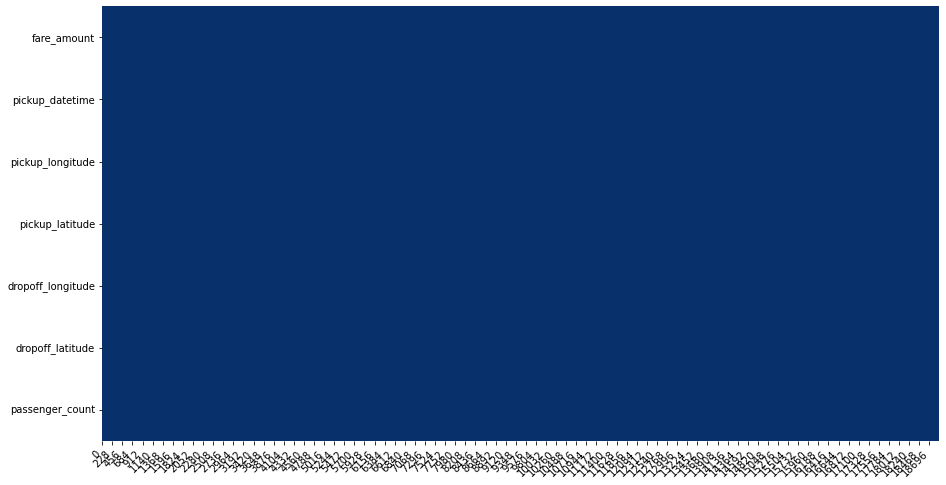

In [3]:
plot_missing_value(df, return_df=True)

In [4]:
df.dropna(inplace=True)

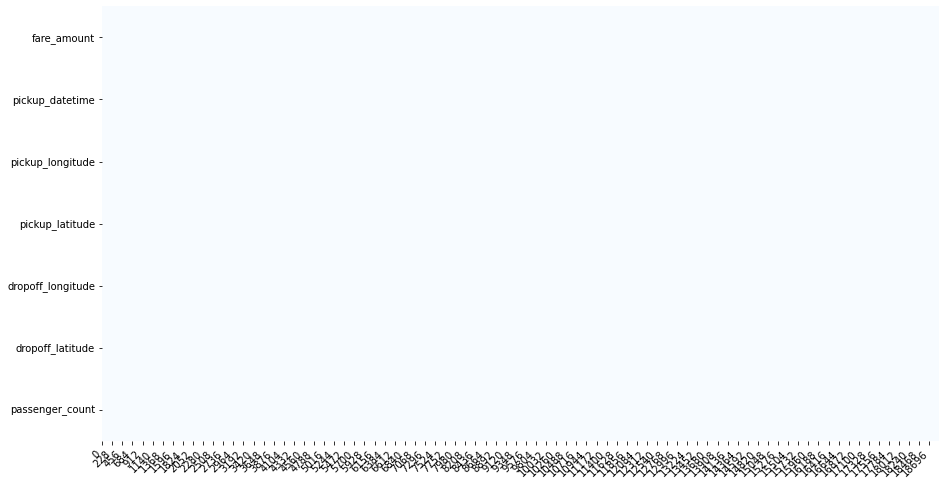

In [5]:
plot_missing_value(df)

# Extract Time Future

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18918 entries, 0 to 18917
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fare_amount        18918 non-null  float64       
 1   pickup_datetime    18918 non-null  datetime64[ns]
 2   pickup_longitude   18918 non-null  float64       
 3   pickup_latitude    18918 non-null  float64       
 4   dropoff_longitude  18918 non-null  float64       
 5   dropoff_latitude   18918 non-null  float64       
 6   passenger_count    18918 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.7 MB


In [7]:
pickup_dt = df.pickup_datetime.dt

In [8]:
df['Year'] = pickup_dt.year
df['Month'] = pickup_dt.month
df['Day'] = pickup_dt.dayofweek
df['Hour'] = pickup_dt.hour
df.drop(columns='pickup_datetime', inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


In [9]:
df['Distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude) 
df.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], inplace=True)
df.head()

,fare_amount,passenger_count,Year,Month,Day,Hour,Distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


# Dataset Splitting

In [10]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

In [11]:
df.head()

,fare_amount,passenger_count,Year,Month,Day,Hour,Distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


In [12]:
X_train.columns

Index(['passenger_count', 'Year', 'Month', 'Day', 'Hour', 'Distance'], dtype='object')

# Training

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [14]:
gsp.linreg_params

{'algo__fit_intercept': [True, False]}

In [15]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['passenger_count','Year','Distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['Month', 'Day', 'Hour']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

model = GridSearchCV(pipeline, gsp.linreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'algo__fit_intercept': True}
0.023086762040528286 0.015618233774764937 0.019173477141517403


# Feature Importance
Jangan melakukan Feature Importance karena score nya masih parah

# Evaluation

### Actual Vs Prediction Plot

In [16]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

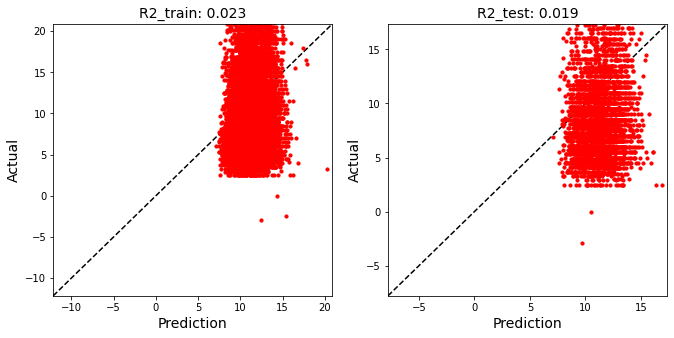

In [17]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

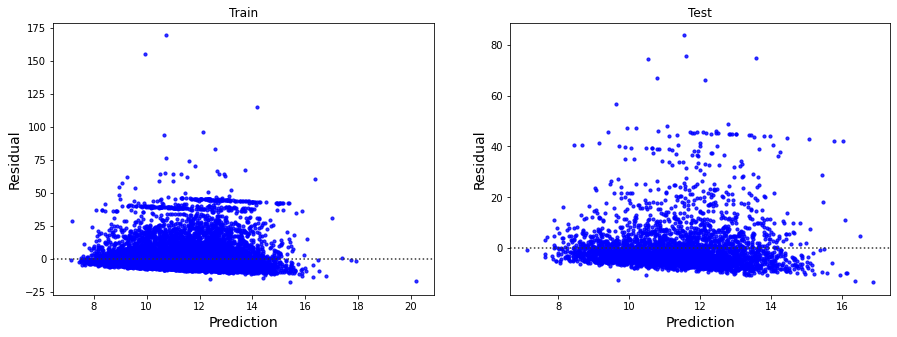

In [18]:
plot_residual(X_train, y_train, X_test, y_test, model)

In [20]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform ='yeo-johnson'), ['passenger_count','Year','Distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['Month', 'Day', 'Hour']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7194858350114898 0.7146987582152398 0.7465474275047523


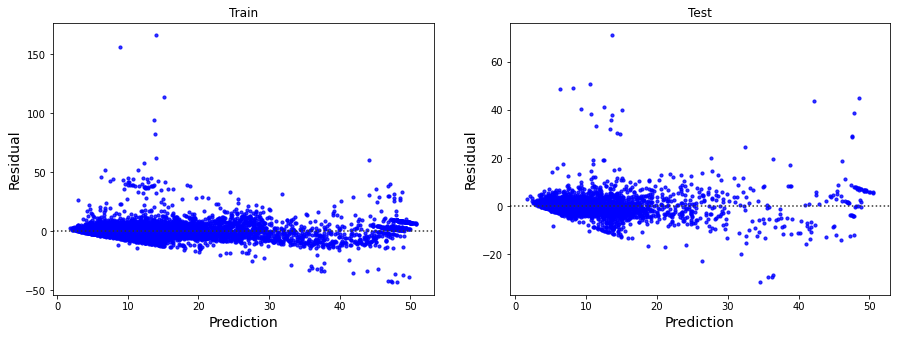

In [21]:
plot_residual(X_train, y_train, X_test, y_test, model)